# 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import matplotlib as mpl
import scipy.stats as stats
import xarray as xr

from matplotlib.collections import LineCollection

import sys
sys.path.append("..")

from pivot import metric
from pivot.transform import PivotSpace
from pivot.plot import plot_grid
import pivot.generate as gen

%load_ext autoreload
%autoreload 2

In [82]:
def distance_distribution_from_random_point(points):
    index = np.random.randint(0, points.shape[0], size=1)
    reference = points[index,:]
    all_dists = transform.metric(reference, points)
    return all_dists

def calc_inherent_dim(all_dists):
    """estimate inherent dimensionality of the metric space from sample distances.
    implements 7.1, definition 9 from https://dl.acm.org/doi/10.1145/502807.502808
    """
    inherent_dim = all_dists.mean()**2 / 2 / all_dists.std(ddof=1)**2
    return inherent_dim

In [3]:
transform = PivotSpace(metric.Euclid(), pivots = np.asarray([[-0.5,0], [0.5,0]]))

In [4]:
points = stats.multivariate_normal(mean=range(200)).rvs(100_000)
all_dists = transform.metric(range(200), points)
calc_inherent_dim(all_dists)

197.6800441602622

In [109]:
points = gen.hyper_unit_grid(5, 1e8)
all_dists = transform.metric([0]*5, points)
calc_inherent_dim(all_dists)

10.934727292699892

In [184]:
n = 10_000
points = stats.multivariate_normal(
    mean=range(200)
).rvs(n)

In [214]:
points = gen.hyper_unit_grid(18,3e8)

In [215]:
shuffle = np.random.permutation(range(points.shape[0]))
points = points[shuffle,:]
dists = np.asarray([
    transform.metric(s, p)
    for s,p in zip(points[:n//2], points[n//2:])
])

calc_inherent_dim(dists)

34.44575284661143

<Axes: ylabel='Count'>

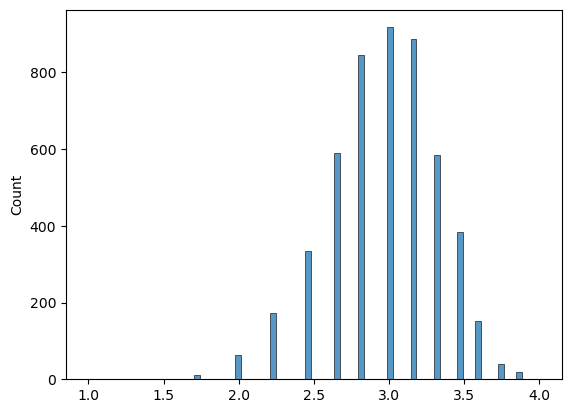

In [217]:
sns.histplot(dists)

In [132]:
_dist(2)

<function __main__.dist(dim)>

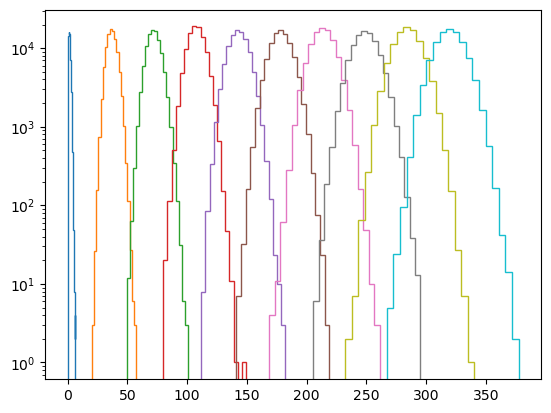

In [145]:
def _dist(dims):
    points = stats.multivariate_normal(
        mean=[0]*dims, 
        cov=np.diag(range(1,dims+1))
    ).rvs(int(1e5))
    all_dists = transform.metric([0]*dims, points)
    return all_dists

dims = range(2,500, 50)
for d in dims:
    plt.hist(_dist(d), bins = 20, histtype="step");
plt.yscale("log")
    
#calc_inherent_dim(all_dists)

<Axes: ylabel='Count'>

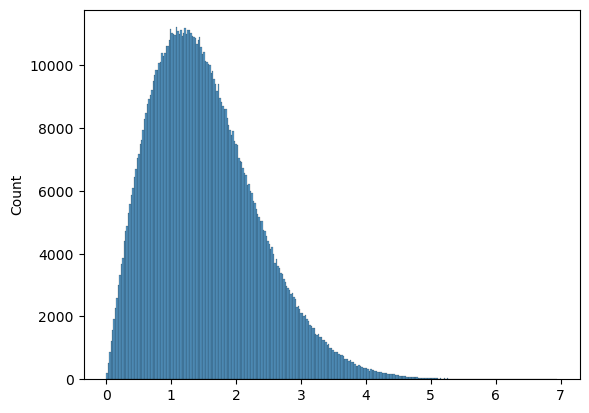

In [126]:
sns.histplot(all_dists)

In [86]:
all_dists.std(), all_dists.mean(), np.quantile(all_dists, 0.5)

(0.1289873984102202, 6.453573571527751, 6.454653327267854)

<Axes: ylabel='Count'>

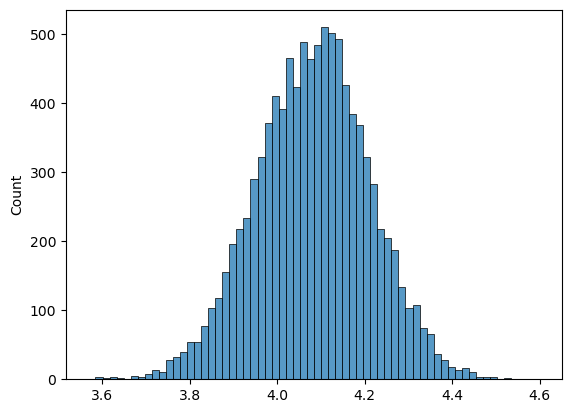

In [71]:
sns.histplot(all_dists)

<Axes: ylabel='Count'>

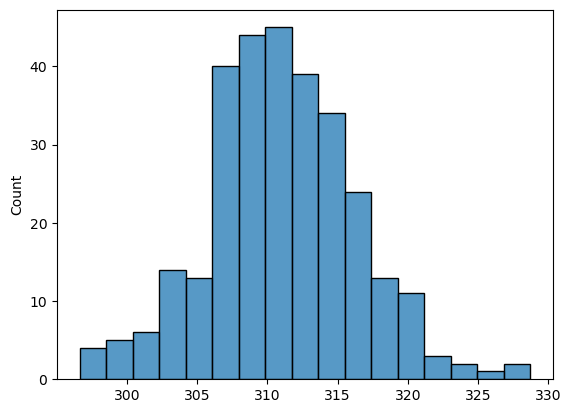

In [72]:
dim_estimates = [calc_inherent_dim(distance_distribution_from_random_point(points)) for _ in range(300)]
sns.histplot(dim_estimates)

In [73]:
min(dim_estimates)

296.6217474299853

<Axes: ylabel='Count'>

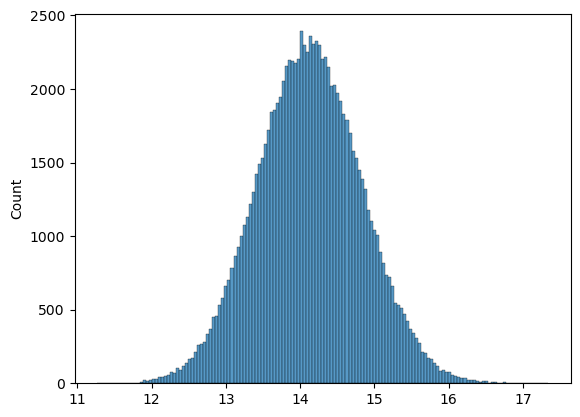

In [17]:
sns.histplot(all_dists)

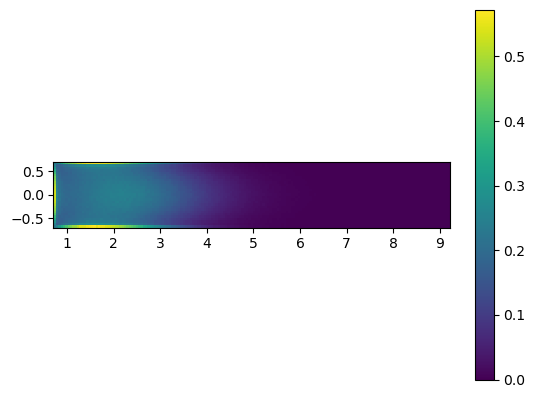

In [6]:
points_piv = transform.transform_points(points)
points_rp = transform.rectify(points_piv)

def binspace(vals, bin_length = 0.05):
    """generates bin edges that are guaranteed to be between vals.min and vals.max
    The actual bin_length can be off by a little bit to accomplish this.""" 
    space = vals.max() - vals.min()
    steps = int(space / bin_length)
    return np.linspace(vals.min(), vals.max()+1e-6, steps)
    
bins = binspace(points_rp[:,0]), binspace(points_rp[:,1])


plt.hist2d(*points_rp.T, bins=bins, density=True) #, norm=mpl.colors.LogNorm());
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

In [5]:
counts, xedges, yedges = np.histogram2d(*points_rp.T, bins=bins)

def bin_centers(edges):
    step_size = edges[1] - edges[0]
    return edges[:-1] + step_size/2

density_piv  = xr.DataArray(
    counts,
    dims=("p1", "p2"),
    coords=dict(p1=bin_centers(xedges), p2=bin_centers(yedges))
)

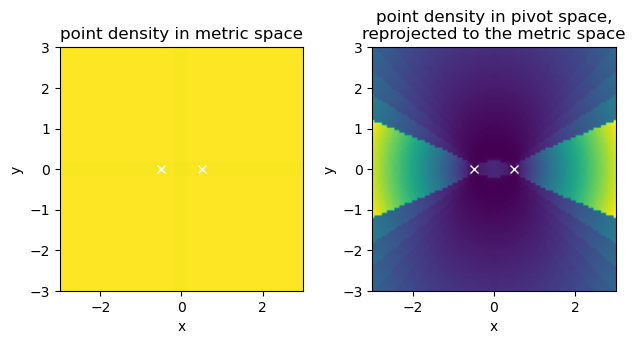

In [6]:
extent = -3,3
lims = np.linspace(*extent, 97)
xx,yy = np.meshgrid(lims, lims)
grid = np.array([xx.flatten(), yy.flatten()]).T

pgrid = transform.transform_points(grid)
tr = transform.rectify(pgrid)
density = density_piv.sel(
    p1=xr.DataArray(tr[:,0], dims="points"),
    p2=xr.DataArray(tr[:,1], dims="points"),
    method="nearest"
)
density = np.asarray(density)

def plot_config():
    plt.plot(*transform.pivots.T, "wx")
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(*extent)
    plt.ylim(*extent)
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    

plt.subplot(1,2,1)
plt.title("point density in metric space")
plt.hist2d(*points.T, bins=29)
plot_config()



plt.subplot(1,2,2)
plt.title("point density in pivot space,\nreprojected to the metric space")
plt.imshow(
    density.reshape(len(lims), len(lims)),
    extent = [*extent, *extent],
)
plot_config()


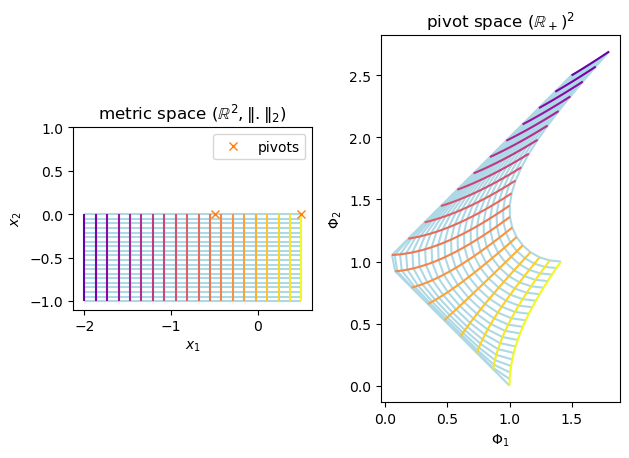

In [7]:
n = 20
xx, yy = np.meshgrid(np.linspace(-2,0.5, n), np.linspace(-1,0,n))

points = np.array([xx.flatten(), yy.flatten()]).T
p_t = transform.transform_points(points)
xx_t, yy_t = p_t.T
xx_t = xx_t.reshape(xx.shape)
yy_t = yy_t.reshape(yy.shape)


cmap_1 = mpl.colormaps['plasma']
config = dict(
    ycolor = cmap_1(np.linspace(0.2,1, xx.shape[0])),
    xcolor = "lightblue",
)

plt.subplot(1,2,1)
plt.title(r"metric space $(\mathbb{R}^2, "+transform.metric.name+")$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plot_grid(xx,yy, **config)
plt.plot(*transform.pivots.T, "x", color="C1", label="pivots");
plt.ylim(-1.1,1)
plt.legend()
plt.gca().set_aspect('equal')

plt.subplot(1,2,2)
plt.title("pivot space $(\mathbb{R}_+)^2$")
plt.xlabel("$\Phi_1$")
plt.ylabel("$\Phi_2$")

plot_grid(xx_t,yy_t, **config)


plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()